# Intervention


In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("mps")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


### 1) Get activations

/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:8: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  batch_idx, seq_idx = (tokens == select_token_id).nonzero(as_tuple=True)
/Users/niklasstoehr/Code/measureLM/measureLM_venv/lib/python3.9/site-packages/torch/functional.py:864: UserWarning: MPS: unique_consecutive op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:332.)
  output, inverse_indices, counts = _VF.unique_consecutive(  # type: ignore[attr-defined]
/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:13: UserWarning: torch.cumsum supported by MPS on MacOS 13+, please upgrade (Triggered int


prompt 0
layer 0: [(0.0001, 'excellent'), (0.0, 'awful'), (0.0002, 'positive'), (0.0001, 'awesome'), (0.0001, 'negative')]
layer 1: [(0.0001, 'excellent'), (0.0, 'awful'), (0.0003, 'positive'), (0.0001, 'awesome'), (0.0001, 'negative')]
layer 2: [(0.0002, 'excellent'), (0.0, 'awful'), (0.0005, 'positive'), (0.0001, 'awesome'), (0.0002, 'negative')]
layer 3: [(0.0002, 'excellent'), (0.0, 'awful'), (0.0019, 'positive'), (0.0001, 'awesome'), (0.0004, 'negative')]
layer 4: [(0.0002, 'excellent'), (0.0, 'awful'), (0.0036, 'positive'), (0.0001, 'awesome'), (0.0006, 'negative')]
layer 5: [(0.0003, 'excellent'), (0.0, 'awful'), (0.0057, 'positive'), (0.0001, 'awesome'), (0.0011, 'negative')]
layer 6: [(0.0002, 'excellent'), (0.0, 'awful'), (0.04, 'positive'), (0.0001, 'awesome'), (0.01, 'negative')]
layer 7: [(0.0003, 'excellent'), (0.0, 'awful'), (0.0476, 'positive'), (0.0001, 'awesome'), (0.003, 'negative')]
layer 8: [(0.0003, 'excellent'), (0.0, 'awful'), (0.0238, 'positive'), (0.0002, 'aw

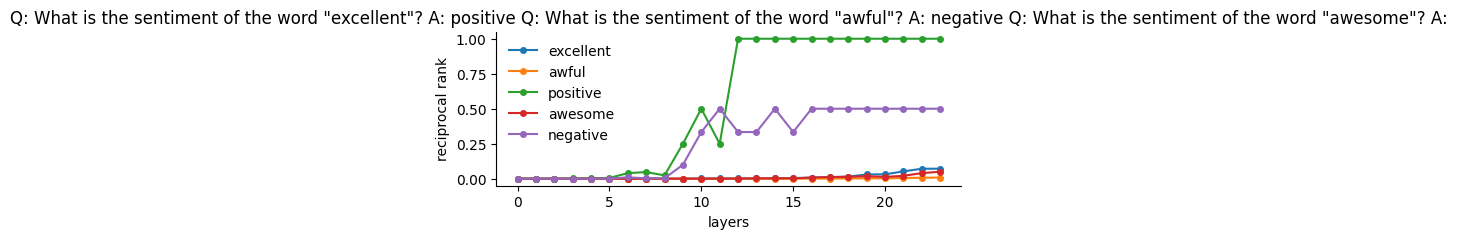

In [3]:
args = [("excellent","positive"), ("awful","negative"), ("awesome","positive")]
prompts = [f'Q: What is the sentiment of the word "{args[0][0]}"? A: {args[0][1]} Q: What is the sentiment of the word "{args[1][0]}"? A: {args[1][1]} Q: What is the sentiment of the word "{args[2][0]}"? A:']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

token_candidates = list(set(itertools.chain(*args)))

tok_idx = scoring.token_select(tokens, model)
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['ĠIt', 'ĠAwesome', 'ĠI']
extracting blocks.0.hook_resid_post
extracting blocks.1.hook_resid_post
extracting blocks.2.hook_resid_post
extracting blocks.3.hook_resid_post
extracting blocks.4.hook_resid_post
extracting blocks.5.hook_resid_post
extracting blocks.6.hook_resid_post
extracting blocks.7.hook_resid_post
extracting blocks.8.hook_resid_post
extracting blocks.9.hook_resid_post
extracting blocks.10.hook_resid_post
extracting blocks.11.hook_resid_post
extracting blocks.12.hook_resid_post
extracting blocks.13.hook_resid_post
extracting blocks.14.hook_resid_post
patching blocks.15.hook_mlp_out
extracting blocks.15.hook_resid_post
patching blocks.16.hook_mlp_out
extracting blocks.16.hook_resid_post
patching blocks.17.hook_mlp_out
extracting blocks.17.hook_resid_post
patching blocks.18.hook_mlp_out
extracting blocks.18.hook_resid_post
patching blocks.19.hook_mlp_out
extracting blocks.19.hook_resid_post
patching blocks.20.hook_mlp_out
extracting blocks.20.hook_resid_post
patching blocks

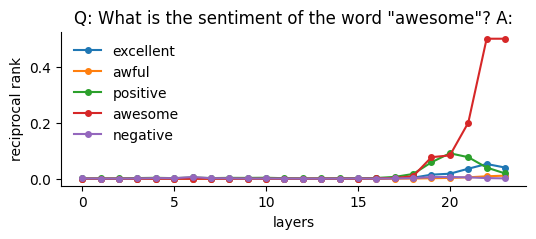

In [7]:
new_prompts = [f'Q: What is the sentiment of the word "{args[2][0]}"? A:']
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

patch_map = patching.create_hook_mapping(model, extract_l=(15, 40), patch_l=(15, 40))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=-1)
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = token_candidates

## scoring
tok_idx = scoring.token_select(new_tokens, model)
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
